In [29]:
from data.data_loader import download_price
import pandas as pd
df = download_price("XOM",start = '2015-10-01',end='2025-10-01')
df.to_csv("XOM.csv")


In [30]:
from data.data_loader import download_price
import pandas as pd
df = download_price("CVX",start = '2015-10-01',end='2025-10-01')
df.to_csv("CVX.csv")


In [33]:
# ======================
# DATA
# ======================
from data.data_loader import load_price
import pandas as pd
import numpy as np
symbol_x = "XOM"
symbol_y = "CVX"

df_x = load_price(symbol_x)
df_y = load_price(symbol_y)

price_x = np.log(df_x["close"])
price_y = np.log(df_y["close"])

price_x, price_y = price_x.align(price_y, join="inner")


In [34]:
# --------------------------------------------------
# 2. BUILD SPREAD (KALMAN)
# --------------------------------------------------
from spread.kalman_beta import KalmanBeta
from spread.builder import SpreadBuilder

kalman = KalmanBeta()
beta_series = kalman.run(price_x, price_y)
spread_builder = SpreadBuilder()
spread = spread_builder.build(price_x, price_y, beta_series)

<Axes: xlabel='Date'>

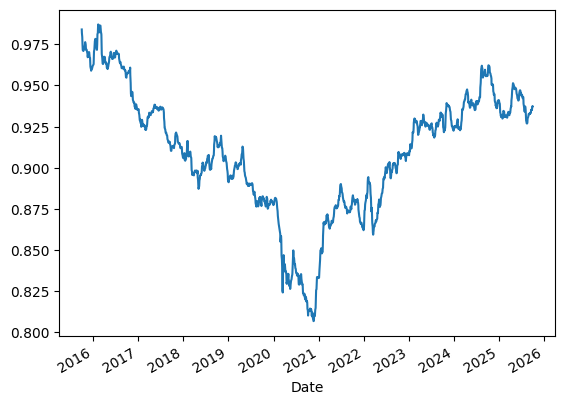

In [35]:
beta_series.plot()

<Axes: xlabel='Date'>

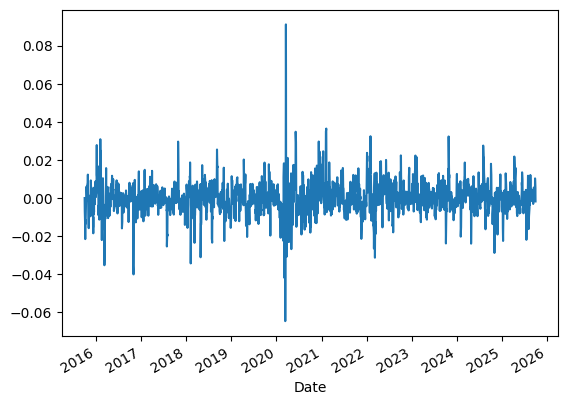

In [36]:
spread.plot()

In [42]:
from regime.config import RegimeConfig
from regime.classifier import RegimeClassifier
config = RegimeConfig()

regime_clf = RegimeClassifier(config)



In [47]:
from trading_signals.zscore import ZScoreSignal
signal_engine = ZScoreSignal(
    window=20,
    entry_z=2.0,
    exit_z=0.5
)


In [82]:
# Đảm bảo truyền List các đối tượng, không phải Dictionary
wf = WalkForwardEngine(
    data = {
        'x' : price_x,
        'y' : price_y,
        'spread' : spread,
        'dates': price_x.index, # Thêm dates nếu engine yêu cầu
        'pair': "KO_PEP"        # Thêm tên cặp để logger hoạt động
    },
    modules = [regime_clf, signal_engine] # Thay {} bằng []
)

In [83]:
results_df = wf.run()


In [85]:
signal_results = results_df['ZScoreSignal']

In [74]:
regime_results = results_df['RegimeClassifier']

In [90]:
import pandas as pd
df_signal = pd.json_normalize(signal_results)

<Axes: >

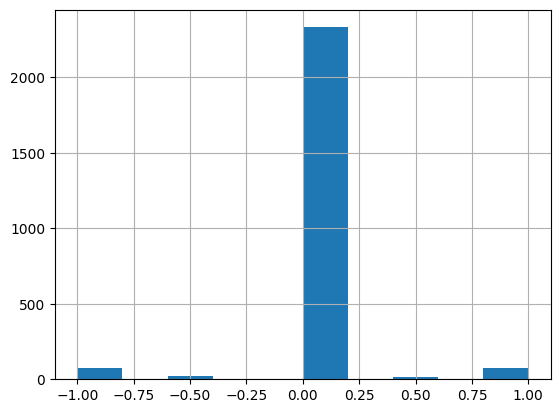

In [114]:
df_signal['position'].value_counts()
df_signal['position'].hist()

In [88]:
import pandas as pd

# Chuyển scores và raw thành các cột riêng
df_regime = pd.json_normalize(regime_results)

# Kết quả:
# df.columns = ['t', 'regime', 'position_multiplier', 'scores.structural', 'scores.mr', ..., 'raw.adf_p', 'raw.coint_p', ...]


<Axes: >

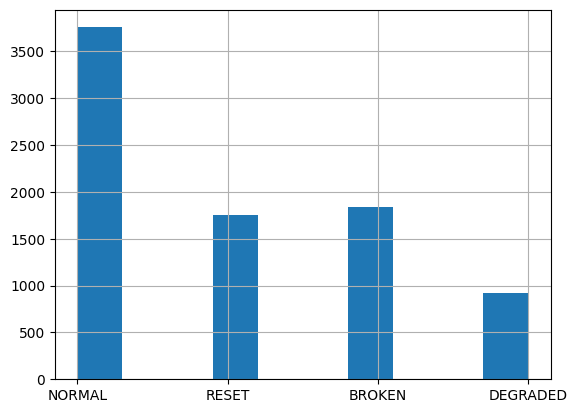

In [113]:
df_regime['regime'].value_counts()
df_regime['regime'].hist()

In [98]:
from execution.backtest import SpreadBacktest

backtester = SpreadBacktest(
    cost_per_turnover=0.0005,  # ví dụ
    slippage=0.0001,
    output_path="backtest_results.csv"  # nếu muốn lưu
)


In [99]:
for t in range(len(df_signal)):
    signal_dict = {"position": df_signal.iloc[t]['position']}
    backtester.step(t=t, spread=spread, ZScoreSignal=signal_dict)


In [100]:
df_backtest = backtester.finalize(index=df_signal.index)


<Axes: >

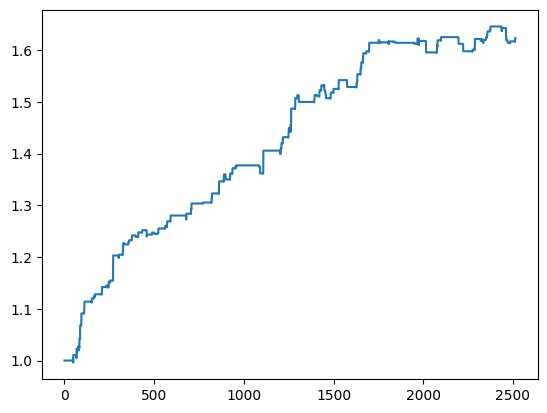

In [102]:
df_backtest['equity'].plot()

<Axes: >

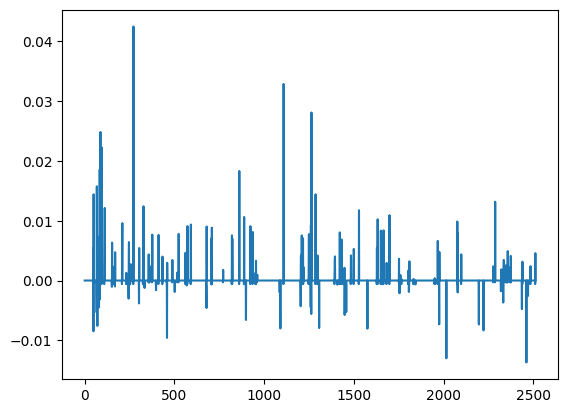

In [106]:
df_backtest['pnl'].plot()

In [115]:
from performance.rolling_metrics import RollingPerformanceMetrics

rolling = RollingPerformanceMetrics(
    csv_path="backtest_results.csv",
    output_path="rolling_metrics.csv",
    freq=252,  # nếu dữ liệu daily
    equity_col="equity",
    pnl_col="pnl",
    position_col="position",
    date_col=None  # nếu chưa có cột date
)


In [118]:
df_rolling = rolling.run(
    sharpe_window=30,# 1 thang
    vol_window=60,
    turnover_window=20,
    exposure_window=20,
    regime_window=60  # nếu có cột regime
)


<Axes: >

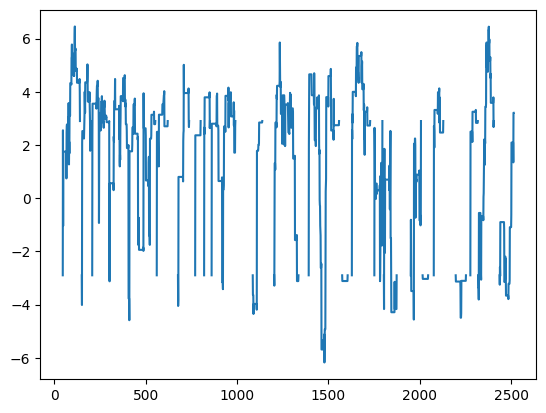

In [120]:
df_rolling['rolling_sharpe_30'].plot()

<Axes: >

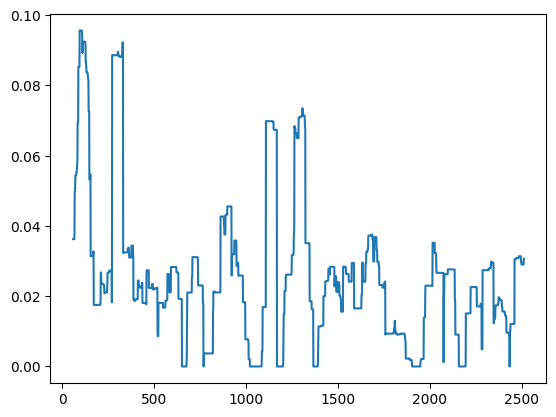

In [121]:
df_rolling['rolling_vol_60'].plot()
#

<Axes: >

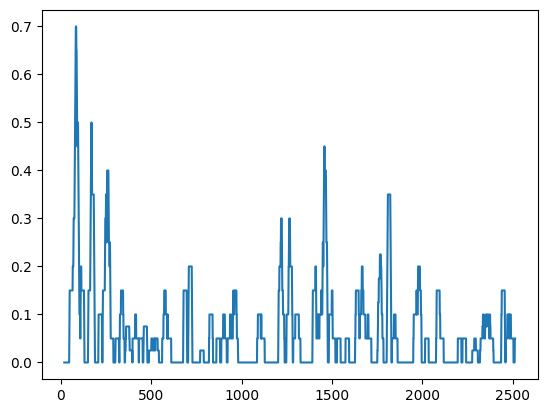

In [122]:
df_rolling['rolling_exposure_20'].plot()

<Axes: >

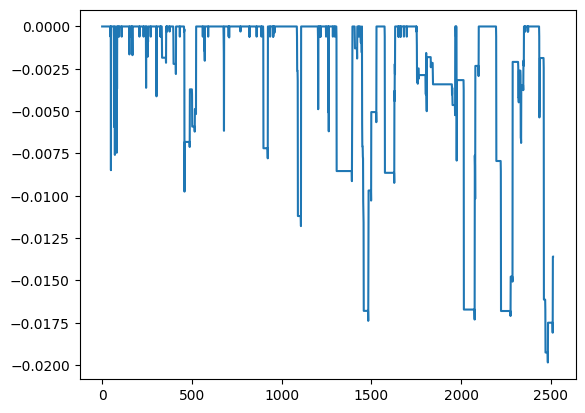

In [123]:
df_rolling['drawdown'].plot()

In [124]:
df_rolling = rolling.run(
    sharpe_window=252,# 1 thang
    vol_window=60,
    turnover_window=20,
    exposure_window=20,
    regime_window=60  # nếu có cột regime
)


<Axes: >

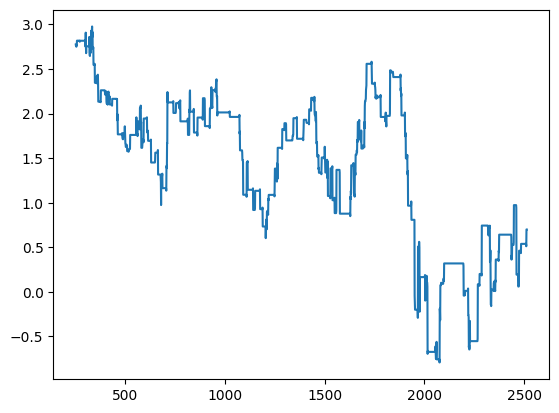

In [125]:
df_rolling['rolling_sharpe_252'].plot()